
# Hierarchical Risk Parity in Python

## Basic configuration

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

---
## Reading files

In [3]:
from os import listdir
import pandas as pd
import pickle
import numpy as np
import time
from os.path import isfile, join
import os
dir = "Data/Stocks/"
import os
onlyfiles = filter(lambda x: os.path.getsize(x) > 200000, [os.path.join(dir, x) for x in os.listdir(dir)])
onlyfiles = map(lambda s : s.replace("Data/Stocks/",""), onlyfiles)
print(len(onlyfiles))
onlyfiles = onlyfiles[:50]

357


In [4]:
df3 = pd.DataFrame()
df2 = pd.DataFrame()
df = pd.DataFrame()
for file_x in onlyfiles:
    try:
        to_remove = pd.read_csv("Data/Stocks/" + file_x, index_col=0)
        if to_remove.shape[0] >= 500:
            df3 = pd.concat([df3,to_remove.Close.pct_change().rename(file_x.replace('.txt',''))], axis=1)
    except:
        pass
print df3.shape

(14065, 50)


In [5]:
df3 = df3[df3.isna().any(axis=1) == False]
percentage = int(df3.shape[0]*.8)
df = df3.iloc[:percentage]
print "The size of sample is", df.shape[0]
print "The size out of sample is", df3.shape[0]-df.shape[0]

The size of sample is 3310
The size out of sample is 828


In [6]:
df.to_csv("Data/Exported/series.csv")
df.cov().to_csv("Data/Exported/cov.csv")
df.corr().to_csv("Data/Exported/corr.csv")

---
## HRP Model

In [7]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch,random,numpy as np,pandas as pd 

In [8]:
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp=1./np.diag(cov) 
    ivp/=ivp.sum() 
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster 
    cov_=cov.loc[cItems,cItems] # matrix slice 
    w_=getIVP(cov_).reshape(-1,1) 
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0] 
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link=link.astype(int) 
    sortIx=pd.Series([link[-1,0],link[-1,1]]) 
    numItems=link[-1,3] # number of original items 
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space 
        df0=sortIx[sortIx>=numItems] # find clusters 
        i=df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0] # item 1
        df0=pd.Series(link[j,1],index=i+1) 
        sortIx=sortIx.append(df0) # item 2 
        sortIx=sortIx.sort_index() # re-sort 
        sortIx.index=range(sortIx.shape[0]) # re-index
    return sortIx.tolist()
#———————————————————————————————————————

def getRecBipart(cov,sortIx):
    # Compute HRP alloc
    w=pd.Series(1,index=sortIx)
    cItems=[sortIx] # initialize all items in one cluster 
    while len(cItems)>0:
        cItems=[i[j:k] for i in cItems for j,k in ((0,len(i)/2), \
                                               (len(i)/2,len(i))) if len(i)>1] # bi-section
        for i in xrange(0,len(cItems),2): # parse in pairs 
            cItems0=cItems[i] # cluster 1 
            cItems1=cItems[i+1] # cluster 2 
            cVar0=getClusterVar(cov,cItems0) 
            cVar1=getClusterVar(cov,cItems1) 
            alpha=1-cVar0/(cVar0+cVar1)
            w[cItems0]*=alpha # weight 1
            w[cItems1]*=1-alpha # weight 2 
    return w
#———————————————————————————————————————

def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1 # This is a proper distance metric
    dist=((1-corr)/2.)**.5 # distance matrix
    return dist
#———————————————————————————————————————

def plotCorrMatrix(path,corr,labels=None): # Heatmap of the correlation matrix
    if labels is None:labels=[] 
    plt.pcolor(corr)
    plt.colorbar() 
    plt.yticks(np.arange(.5,corr.shape[0]+.5),labels) 
    plt.xticks(np.arange(.5,corr.shape[0]+.5),labels) 
    #plt.savefig(path)
    plt.show()
    plt.clf();plt.close() # reset pylab
    return

In [9]:
def plot(link):
    # calculate full dendrogram
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('saplte index')
    plt.ylabel('distance')
    sch.dendrogram(
        link,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    )
    plt.show()

In [10]:
def main():
    cov,corr=df.cov(),df.corr()
    #2) compute and plot correl matrix 
    plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns) 
    
    #3) cluster
    dist=correlDist(corr)
    link=sch.linkage(dist,'single')
    plot(link)
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() # recover labels 
    df0=corr.loc[sortIx,sortIx] # reorder 
    plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    
    #4) Capital allocation
    hrp=getRecBipart(cov,sortIx) 
    return hrp, df0

---
# Markowitz

In [11]:
n_portfolios = 50000

In [12]:
returns_annual = ((df.mean() + 1) ** 250) - 1 # Correct formula
selected = df.columns

# get daily and covariance of returns of the stock
cov_daily = df.cov()
cov_annual = cov_daily * 250

In [13]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df_m = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock for stock in selected]

# reorder dataframe columns
df_m = df_m[column_order]

# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df_m['Volatility'].min()
max_sharpe = df_m['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df_m.loc[df_m['Sharpe Ratio'] == max_sharpe]
min_variance_port = df_m.loc[df_m['Volatility'] == min_volatility]

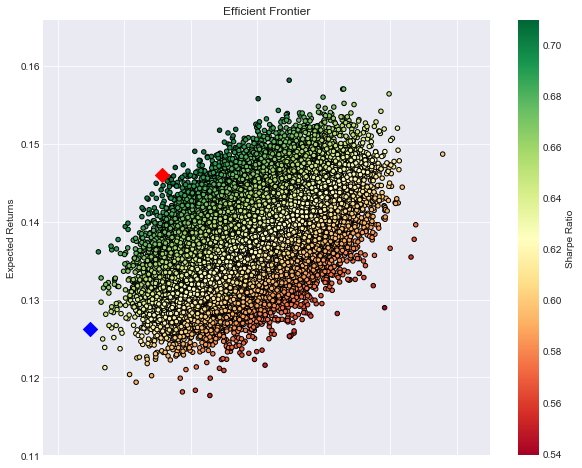

In [14]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df_m.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)

plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=100)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=100)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

---
## Result
### HRP

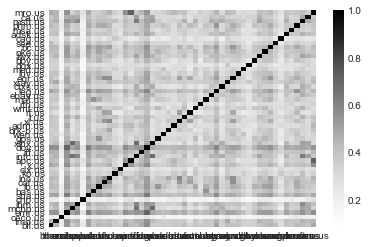

/Users/MikeW/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


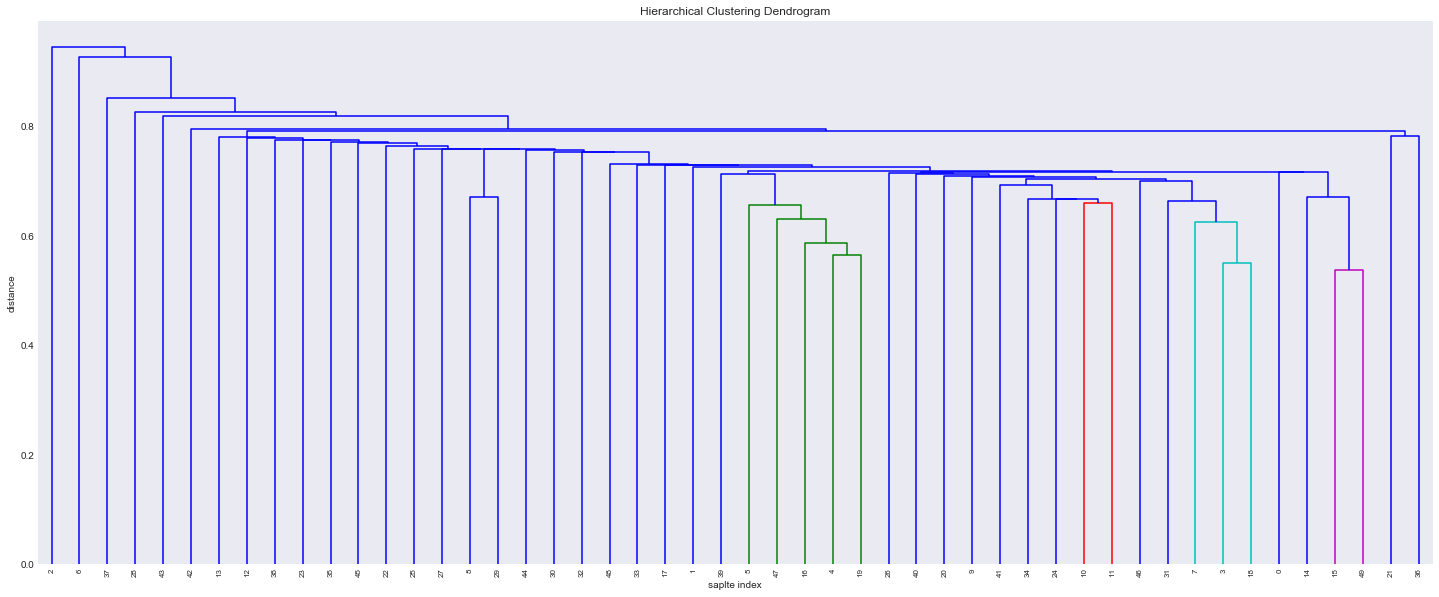

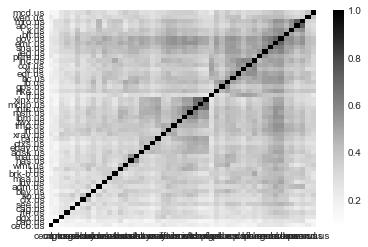

In [15]:
hrp, corr = main()

In [16]:
hrp.sum()

1.0

In [17]:
def anualized(row):
    anual = 1
    for i in row.values:
        anual = (anual)*(i+1)
    anual -= 1
    return anual

In [18]:
print "Anual returns on sample:",(((df.mean()*hrp)).sum() + 1)**250 -1
print "Anual returns out of sample:", ((df3.iloc[percentage:,:].mean()*hrp).sum()+1)**250-1

Anual returns on sample: 0.11844680546910769
Anual returns out of sample: 0.13867752804412947


---
### Markowitz

In [19]:
sharpe_portfolio

,Returns,Volatility,Sharpe Ratio,bll.us,tmo.us,ceco.us,emr.us,mchp.us,ibm.us,cnp.us,...,nke.us,bc.us,see.us,cag.us,adsk.us,msa.us,phm.us,msft.us,ca.us,mro.us
31487,0.145947,0.205716,0.70946,0.042328,0.027174,0.029094,0.01895,0.04657,0.026195,0.006008,...,0.025852,0.020904,0.030829,0.038784,0.046083,0.047773,0.020108,0.023376,0.011994,0.020485


In [20]:
min_variance_port

,Returns,Volatility,Sharpe Ratio,bll.us,tmo.us,ceco.us,emr.us,mchp.us,ibm.us,cnp.us,...,nke.us,bc.us,see.us,cag.us,adsk.us,msa.us,phm.us,msft.us,ca.us,mro.us
13529,0.126267,0.194833,0.648081,0.035646,0.005865,0.034874,0.003101,0.024516,0.043125,0.013549,...,0.008907,0.00084,0.038995,0.037905,0.011596,0.028204,0.030188,0.042074,0.014366,0.023326


---
## Creating db

In [21]:
#record = pd.DataFrame(columns=["n_assets", "assets", "w", "return",'return_oos', "sharpe_ratio", "volatility", "timestamp","type","n_samples","n_oos"])
#record = pickle.load(open("records.p"))
record = pd.read_csv("records.csv", index_col=0)
timestamp = time.time()

In [22]:
record = record.append({"n_assets":df.shape[1],"assets":hrp.index.tolist(),"w":hrp.values.tolist(),"sharpe_ratio":(df.mean()*hrp*250).sum()/np.dot(df.std(),hrp),"volatility":np.dot(df.std(),hrp),"return":(df.mean()*hrp*250).sum(),"return_oos":(df3[percentage:].mean()*hrp*250).sum(), "timestamp":timestamp, "type":"hrp", "n_samples":percentage, "n_oos": (df3.shape[0]-percentage)}, ignore_index=True)
record = record.append({"n_assets":df.shape[1],"assets":df.columns.tolist(),"w":min_variance_port.iloc[0,3:].values,"sharpe_ratio":min_variance_port.iloc[0,2],"volatility":min_variance_port.iloc[0,1],"return":min_variance_port.iloc[0,0], "return_oos":(df3[percentage:].mean()*min_variance_port.iloc[0,3:]).sum()*250, "timestamp":timestamp, "type":"min_variance", "n_samples":percentage, "n_oos": (df3.shape[0]-percentage)}, ignore_index=True)
record = record.append({"n_assets":df.shape[1],"assets":df.columns.tolist(),"w":sharpe_portfolio.iloc[0,3:].values,"sharpe_ratio":sharpe_portfolio.iloc[0,2],"volatility":sharpe_portfolio.iloc[0,1],"return":sharpe_portfolio.iloc[0,0],"return_oos":(df3[percentage:].mean()*sharpe_portfolio.iloc[0,3:]).sum()*250, "timestamp":timestamp, "type":"best_sharpe", "n_samples":percentage, "n_oos": (df3.shape[0]-percentage)}, ignore_index=True)


In [23]:
record

,n_assets,assets,w,return,return_oos,sharpe_ratio,volatility,timestamp,type,n_samples,n_oos
0,357,"['Data/Stocks/nem.us', 'Data/Stocks/kgc.us', '...","[0.0016005591459567145, 0.0008888521472822684,...",0.106944,0.124353,4.932318,0.021682,1.524413e+09,hrp,1488,373
1,357,"['Data/Stocks/bll.us', 'Data/Stocks/tmo.us', '...",[6.05075094e-04 5.26901973e-03 2.19972570e-03 ...,0.135803,0.139053,0.809648,0.167731,1.524413e+09,min_variance,1488,373
2,357,"['Data/Stocks/bll.us', 'Data/Stocks/tmo.us', '...",[2.46295083e-03 2.24998664e-03 3.25752990e-03 ...,0.193869,0.169441,1.128179,0.171842,1.524413e+09,best_sharpe,1488,373
3,50,"['Data/Stocks/ceco.us', 'Data/Stocks/cnp.us', ...","[0.010151075465833057, 0.01968422828764637, 0....",0.111966,0.129901,5.012810,0.022336,1.524415e+09,hrp,3310,828
4,50,"['Data/Stocks/bll.us', 'Data/Stocks/tmo.us', '...",[0.03564615 0.00586496 0.03487444 0.00310052 0...,0.126267,0.126594,0.648081,0.194833,1.524415e+09,min_variance,3310,828
5,50,"['Data/Stocks/bll.us', 'Data/Stocks/tmo.us', '...",[0.04232813 0.02717436 0.02909432 0.0189497 0...,0.145947,0.145524,0.709460,0.205716,1.524415e+09,best_sharpe,3310,828
6,5,"bll.us, tmo.us, ceco.us, emr.us, mchp.us","0.324033089552625, 0.186350061647673, 0.129095...",0.173094,0.144699,0.666739,0.259613,1.524435e+09,hrp,3164,791
7,5,"bll.us, tmo.us, ceco.us, emr.us, mchp.us","0.324033089552625, 0.186350061647673, 0.129095...",0.173094,0.144699,7.250650,0.023873,1.524438e+09,hrp,3164,791
8,5,"bll.us, tmo.us, ceco.us, emr.us, mchp.us","0.377502608910749, 0.233650936367892, 0.057951...",0.148282,0.168760,6.865915,0.021597,1.524438e+09,best_sharpe,3164,791
9,5,"bll.us, tmo.us, ceco.us, emr.us, mchp.us","0.4, 0.172428540792726, 0.145655545068664, 0.0...",0.204279,0.147467,7.875907,0.025937,1.524438e+09,min_variance,3164,791


---
## Exporting

In [24]:
#pickle.dump(record, open("records.p",'wb'))
record.to_csv("records.csv")
pickle.dump(hrp, open("outputs/" + str(timestamp) + "_" + str(df.shape[0]) + "stocks_hrp.p", 'wb'))
pickle.dump(df, open("outputs/" + str(timestamp) + "_" + str(df.shape[0]) + "stocks_df.p", 'wb'))
pickle.dump(corr, open("outputs/" + str(timestamp) + "_" + str(df.shape[0]) + "stocks_corr.p", 'wb'))